In [1]:
import torch
from torch import nn

In [21]:
torch.tensor([1]),torch.Tensor([1])

(tensor([1]), tensor([1.]))

In [44]:
from d2l_common import DataModule, Vocab


class MTFraEng(DataModule):
    """The English-French dataset."""

    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super().__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else (self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        raw_txt = '\n'.join([src+'\t'+tgt for src,tgt in zip(src_sentences,tgt_sentences)])
        arrays,_,_ = self._build_arrays(raw_txt, self.src_vocab,self.tgt_vocab)
        return arrays

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            def pad_or_trim(seq, t): return (seq[:t] if len(seq) > t else seq+['<pad>']*(t-len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>']+s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(
            raw_text), self.num_train+self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:]), src_vocab, tgt_vocab)

    def _download(self):
        with open('../data/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text: str):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        def no_space(
            char, prev_char): return char in ',.!?' and prev_char != ' '
        out = [' '+char if i > 0 and no_space(char, text[i-1])
               else char for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text: str, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples:
                break
            parts = line.split('\t')
            if len(parts) == 2:
                src.append([t for t in parts[0].split(' ') if t]+['<eos>'])
                tgt.append([t for t in parts[1].split(' ') if t]+['<eos>'])
        return src, tgt

In [45]:
[['<bos>'] +s for s in [['a'],['b']]],['<bos>'] +[s for s in [['a'],['b']]]


([['<bos>', 'a'], ['<bos>', 'b']], ['<bos>', ['a'], ['b']])

In [46]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[117, 182,   0,   3,   4,   4,   4,   4,   4],
        [ 95, 124,   2,   3,   4,   4,   4,   4,   4],
        [ 29, 119,   0,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 100,  58, 160,   0,   4,   5,   5,   5],
        [  3,   6, 146,   2,   4,   5,   5,   5,   5],
        [  3,   6,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[100,  58, 160,   0,   4,   5,   5,   5,   5],
        [  6, 146,   2,   4,   5,   5,   5,   5,   5],
        [  6,   0,   4,   5,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [47]:
src, tgt, _, _ = data.build(['hi .'],['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [40]:
data = MTFraEng()
raw_txt = data._download()
print(raw_txt[:100])

TypeError: MTFraEng.__init__() missing 1 required positional argument: 'batch_size'

In [10]:
text = data._preprocess(raw_txt)
print(text[:100])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
fire !	au feu !
hel


In [14]:
src,tgt = data._tokenize(text)
src[:10],tgt[:10]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>'],
  ['fire', '!', '<eos>'],
  ['help', '!', '<eos>'],
  ['jump', '.', '<eos>'],
  ['stop', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>'],
  ['au', 'feu', '!', '<eos>'],
  ['à', "l'aide", '!', '<eos>'],
  ['saute', '.', '<eos>'],
  ['ça', 'suffit', '!', '<eos>']])

In [15]:
import matplotlib.pyplot as plt


def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    plt.figure(figsize=(6, 3))
    _, _, patches = plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

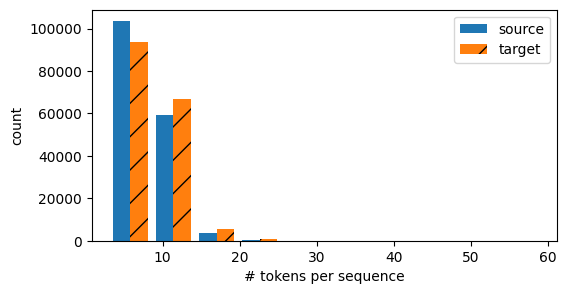

In [16]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);